In [1]:
import os
os.chdir('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis')
print("Working Directory:", os.getcwd())
import ipywidgets as widgets
import pandas as pd
from pandas.io.json import json_normalize
import json
from pprint import pprint
import threading
from IPython.display import display
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import re
from nonverbal_communication_analysis.environment import OPENFACE_OUTPUT_DIR, OPENPOSE_OUTPUT_DIR, VALID_OUTPUT_FILE_TYPES

Working Directory: /home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis


In [2]:
groups_list = os.listdir(OPENPOSE_OUTPUT_DIR)

GROUP_ID = widgets.Dropdown(
    options=groups_list,
    value=groups_list[-1],
    description='Group:',
    disabled=False,
)
display(GROUP_ID)

Dropdown(description='Group:', index=3, options=('3CLC9VWRSAMPLE_447frames.zip', 'walking_happy_output.tar.gz'…

In [3]:
def is_valid_pose(pose_keypoints):
    invalid_entries = 0
    invalid_keypoint = {-1, -1, 0}
    for idx, keypoints in pose_keypoints.items():
        if set(keypoints) == invalid_keypoint:
            invalid_entries += 1
            
    return len(pose_keypoints) - invalid_entries

def is_valid_face(face_keypoints):
    invalid_entries = 0
    invalid_keypoint = {-1, -1, 0}
    for idx, keypoints in face_keypoints.items():
        if set(keypoints) == invalid_keypoint:
            invalid_entries += 1
            
    return len(face_keypoints) - invalid_entries

In [4]:
%%time

openpose_frame_metrics = pd.DataFrame(columns=['camera', 'n_subjects', 'valid_poses', 'valid_faces'])

if not os.path.isfile('openpose_metrics_df.csv'):
        for camera in range(1,4):
            camera_name = '/output_pc%s/' % camera
            _dir = OPENPOSE_OUTPUT_DIR/(GROUP_ID.value+camera_name)
            input_files = [_dir/file for file in _dir.iterdir() if file.suffix in VALID_OUTPUT_FILE_TYPES]
            input_files.sort()
            total_files = len(input_files)
            print("Found: %s files on %s" % (total_files, camera_name))

            for file in input_files[:]:
                data = json.load(open(file))
                df = pd.json_normalize(data['people'])
                openpose_frame_metrics = openpose_frame_metrics.append({'camera': camera, 'n_subjects': len(df['person_id']), 'valid_poses': is_valid_pose(df['pose_keypoints_2d']), 'valid_faces': is_valid_face(df['face_keypoints_2d'])}, ignore_index=True)
            openpose_frame_metrics.to_csv('openpose_metrics_df.csv')
else:
    openpose_frame_metrics = pd.read_csv('openpose_metrics_df.csv', usecols=['camera', 'n_subjects', 'valid_poses', 'valid_faces'])

CPU times: user 44.1 ms, sys: 8 ms, total: 52.1 ms
Wall time: 51.9 ms


## Openpose

In [5]:
openpose_frame_metrics

,camera,n_subjects,valid_poses,valid_faces
0,1,4,4,2
1,1,4,4,2
2,1,4,4,2
3,1,4,4,2
4,1,4,4,2
...,...,...,...,...
216529,3,4,0,0
216530,3,5,0,0
216531,3,6,0,0
216532,3,7,0,0


In [6]:
total_frames = len(openpose_frame_metrics[openpose_frame_metrics['camera']==1])
subjects_pose_distribution = openpose_frame_metrics.groupby(['camera', 'valid_poses']).count()
subjects_pose_distribution

n_subjects  valid_faces
camera valid_poses                         
1      0                     8            8
       1                     8            8
       2                   323          323
       3                  6862         6862
       4                 59997        59997
       5                  4774         4774
       6                   208          208
       7                     5            5
       8                     1            1
2      0                     8            8
       2                    17           17
       3                  2839         2839
       4                 66166        66166
       5                  3023         3023
       6                   124          124
       7                     6            6
       8                     3            3
3      0                     8            8
       3                   201          201
       4                 66456        66456
       5                  5325         5325
       6                   149          149
       7                    23           23

In [7]:
subjects_face_distribution = openpose_frame_metrics.groupby(['camera', 'valid_faces']).count()
subjects_face_distribution

n_subjects  valid_poses
camera valid_faces                         
1      0                  3086         3086
       1                 18049        18049
       2                 34744        34744
       3                 12903        12903
       4                  3404         3404
2      0                  7257         7257
       1                 39620        39620
       2                 24211        24211
       3                  1082         1082
       4                    16           16
3      0                  3411         3411
       1                 16798        16798
       2                 27400        27400
       3                 20187        20187
       4                  4348         4348
       5                    18           18

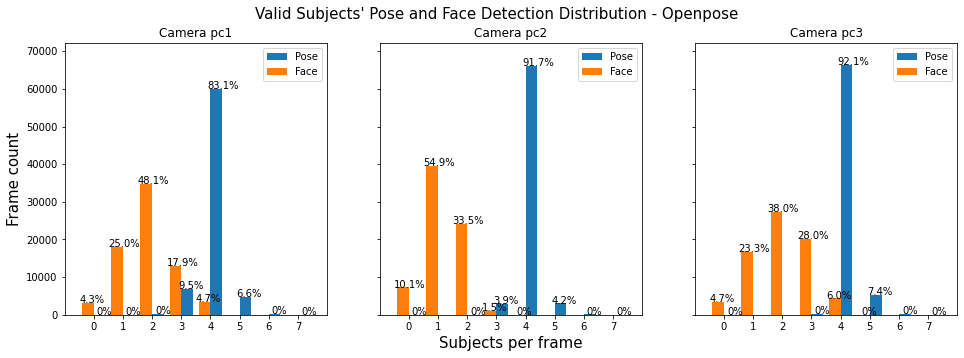

In [8]:
plot_x_max = 8
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(16,5))

fig.suptitle('Valid Subjects\' Pose and Face Detection Distribution - Openpose', size=15)
axes[1].set_xlabel('Subjects per frame', size=15)
axes[0].set_ylabel('Frame count', size=15)
for idx, ax in enumerate(axes):
    idx += 1
    ax.set_title('Camera pc'+str(idx))
    ax.bar(x=subjects_pose_distribution.loc[idx].index+0.2, height=subjects_pose_distribution.loc[idx]['n_subjects'], width=0.4, label='Pose')
    ax.bar(x=subjects_face_distribution.loc[idx].index-0.2, height=subjects_face_distribution.loc[idx]['n_subjects'], width=0.4, label='Face')
    ax.set_xlim([-1, plot_x_max])
    ax.set_xticks(np.arange(plot_x_max))
    ax.set_ylim([0, total_frames])
    ax.legend()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height/total_frames*100
        if round(percentage) == 0:
            ax.annotate('0%', (x+0.1, y + height + 0.1))
        else:
            ax.annotate('%.1f%%' % percentage, (x-0.1, y + height + 0.1))
plt.show()

## Openface

In [9]:
%%time
openface_frame_metrics = pd.DataFrame(columns=['camera', 'frame', 'face_id', 'valid_face'])

if not os.path.isfile('openface_metrics_df.csv'):
    path = "DATASET_DEP/OPENFACE/" + GROUP_ID.value
    tasks_dirs = [x for x in Path(path).iterdir()]
    for task_dir in tasks_dirs:
        openface_files = [x for x in task_dir.iterdir() if x.suffix in VALID_OUTPUT_FILE_TYPES]
        openface_files.sort()

        for file in openface_files[:]:
            camera_id = re.search(r'(?<=Video)(pc\d{1})(?=\d{14})', file.name).group(0) 
            df = pd.read_csv(file)
            
            for _, row in df.iterrows():
                openface_frame_metrics = openface_frame_metrics.append({'camera': camera_id, 'frame': row['frame'], 'face_id': row[' face_id'], 'valid_face': row[' success'] == 1}, ignore_index=True)
    openface_frame_metrics.to_csv('openface_metrics_df.csv')
else:
    openface_frame_metrics = pd.read_csv('openface_metrics_df.csv', usecols=['camera', 'frame', 'face_id', 'valid_face'])

CPU times: user 87 ms, sys: 3.69 ms, total: 90.6 ms
Wall time: 89.2 ms


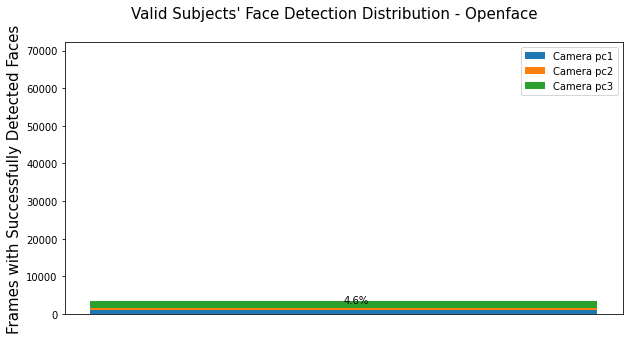

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

fig.suptitle('Valid Subjects\' Face Detection Distribution - Openface', size=15)
ax.set_xlabel('something', size=15)
ax.set_ylabel('Frames with Successfully Detected Faces', size=15)
valid_face_camera = None
for camera_id in openface_frame_metrics['camera'].unique():
    prev = 0 if valid_face_camera is None else prev + valid_face_camera
    valid_face_camera = openface_frame_metrics[(openface_frame_metrics['valid_face']==True) \
                                 & (openface_frame_metrics['camera']==camera_id)]['frame'].count()
    ax.set_ylim([0, total_frames])
    ax.get_xaxis().set_visible(False)
    ax.bar(0, valid_face_camera, width=.2, bottom=prev, label='Camera '+str(camera_id))
    ax.legend()

total_frames_with_faces = openface_frame_metrics[(openface_frame_metrics['valid_face']==True)]['frame'].count()
ax.annotate('%.1f%%' % (int(total_frames_with_faces)/total_frames*100), (0, y+3000 + height + 0.1))
plt.show()

## Openpose Faces Detection VS Openface Face Detection

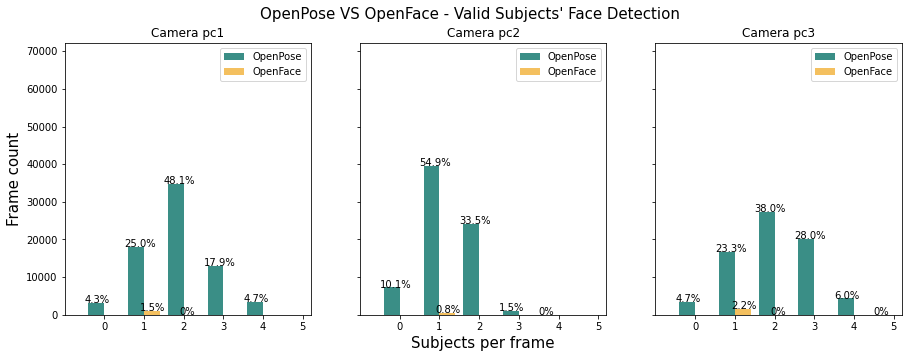

In [24]:
openface_subjects_face_distribution = openface_frame_metrics[openface_frame_metrics['valid_face']==True].groupby(['camera', 'frame']).count().groupby(['camera', 'valid_face']).count()

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(15,5))
fig.suptitle('OpenPose VS OpenFace - Valid Subjects\' Face Detection', size=15)
axes[1].set_xlabel('Subjects per frame', size=15)
axes[0].set_ylabel('Frame count', size=15)

for idx, ax in enumerate(axes):
    idx += 1
    ax.set_title('Camera pc'+str(idx))
    openpose_bars = ax.bar(x=subjects_face_distribution.loc[idx].index-0.2, height=subjects_face_distribution.loc[idx]['n_subjects'], width=0.4, color='#3a8e86', label='OpenPose')
    openface_bars = ax.bar(x=openface_subjects_face_distribution.loc['pc'+str(idx)].index+0.2, height=openface_subjects_face_distribution.loc['pc'+str(idx)]['face_id'], width=0.4, color='#f4c05f', label='OpenFace')
    ax.set_xlim([-1, 5.2])
    ax.set_xticks(np.arange(6))
    ax.set_ylim([0,total_frames])
    ax.legend()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height/total_frames*100
        if round(percentage) == 0:
            ax.annotate('0%', (x-0.1, y + height + 0.1))
        else:
            ax.annotate('%.1f%%' % percentage, (x-0.1, y + height + 0.1))
plt.show()

In [12]:
subjects_face_distribution

n_subjects  valid_poses
camera valid_faces                         
1      0                  3086         3086
       1                 18049        18049
       2                 34744        34744
       3                 12903        12903
       4                  3404         3404
2      0                  7257         7257
       1                 39620        39620
       2                 24211        24211
       3                  1082         1082
       4                    16           16
3      0                  3411         3411
       1                 16798        16798
       2                 27400        27400
       3                 20187        20187
       4                  4348         4348
       5                    18           18

## Simple Visualization

In [13]:
# fig, ax = plt.subplots()
# image = cv2.imread('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis/DATASET_DEP/SYNC/3CLC9VWR/last_frame_vidpc1.png')
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # scaled_img = np.interp(image, (image.min(), image.max()), (-1, +1))
# ax.set_xlim(-1, 1)
# ax.set_ylim(1, -1)
# ax.imshow(image, aspect='auto', extent=(-1,1,1,-1), alpha=1, zorder=-1)
# colors = ['blue', 'orange', 'green', 'red', 'yellow']
# for i in range(len(df['pose_keypoints_2d'])):
#     ndf = pd.DataFrame(([frame['pose_keypoints_2d'][i][x:x+3] for x in range(0, len(frame['pose_keypoints_2d'][i]), 3)]), columns=['x', 'y', 'confidence'])
#     ax.set_title('Person Keypoints Position')
#     ax.scatter(ndf['x'], ndf['y'], c=colors[i])
#     ax.annotate(i, (ndf['x'][i], ndf['y'][i]), c='yellow')

# plt.show()

## Between Shoulders Distance Analysis

In [14]:
shoulder_distance = pd.read_csv('shoulder_distance_sample.csv')
shoulder_distance = shoulder_distance.round(5)

In [15]:
# distance_counts = pd.DataFrame(shoulder_distance['between_shoulders_distance'].value_counts())
# distance_counts['distance'] = distance_counts.index
# distance_counts.sort_values(by='distance')

In [16]:
print("Threshold value:")
shoulder_distance.describe().loc['std'] / shoulder_distance.describe().loc['mean']

Threshold value:


between_shoulders_distance    0.509134
dtype: float64

In [17]:
distance_counts['distance'].hist()

NameError: name 'distance_counts' is not defined